In [1]:
# Reference: https://towardsdatascience.com/k-means-clustering-8e1e64c1561c

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

import nltk
import string
import seaborn            as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import os, sys, email,re

# Dataset

In [4]:
df = pd.read_csv('D:\Projects\Jupyter\Github Docs\datasets\preprocessed_word_correct_token.csv', encoding='utf-8')
df.head()

,id,name,content,sentence,review_score,review_votes,readability,preprocessed_reviews,wordtoken,correctmapping,ngrams_reviews,ngrams_token,lda_reviews,lda_token
0,275850,No Man's Sky,This was my review prior to the 1.1 update ___...,This was my review prior to the 1.1 update ___...,1,1,17.6,this be my review prior to the update nothis g...,"['this', 'be', 'my', 'review', 'prior', 'to', ...","['this', 'be', 'my', 'review', 'prior', 'to', ...",this be my review prior to the update nothin g...,"['review', 'prior', 'update', 'nothin', 'fail'...",review prior update nothin fail miserably anno...,"['review', 'prior', 'update', 'nothin', 'fail'..."
1,275850,No Man's Sky,This was my review prior to the 1.1 update ___...,"When the game first came out it had over 200,0...",1,1,6.5,when the game first come out it have over play...,"['when', 'the', 'game', 'first', 'come', 'out'...","['when', 'the', 'game', 'first', 'come', 'out'...",when the game first come out it have over play...,"['first', 'player', 'one', 'point', 'mear']",first come player one point mear,"['first', 'player', 'one', 'point', 'mear']"
2,275850,No Man's Sky,This was my review prior to the 1.1 update ___...,If that doesn't prove this game is the biggest...,1,1,5.6,if that do not prove this game be the big scam...,"['if', 'that', 'do', 'not', 'prove', 'this', '...","['if', 'that', 'do', 'not', 'prove', 'this', '...",if that do not prove this game be the big scam...,"['prove', 'this_game', 'big', 'scam', 'know']",prove big scam know,"['prove', 'big', 'scam', 'know']"
3,275850,No Man's Sky,This was my review prior to the 1.1 update ___...,The devs completely lied about countless featu...,1,1,8.7,the developer completely lie about countless f...,"['the', 'developer', 'completely', 'lie', 'abo...","['the', 'developer', 'completely', 'lie', 'abo...",the developer completely lie about countless f...,"['the_developer', 'completely', 'lie_about', '...",developer completely lie countless feature meant,"['developer', 'completely', 'lie', 'countless'..."
4,275850,No Man's Sky,This was my review prior to the 1.1 update ___...,______________________________________________...,1,1,29.1,i clearly have very strong feel about the game...,"['clearly', 'have', 'very', 'strong', 'feel', ...","['clearly', 'have', 'very', 'strong', 'feel', ...",clearly have very strong feel about the game a...,"['clearly', 'strong', 'feel', 'play', 'hour', ...",clearly strong feel play hour hello games rele...,"['clearly', 'strong', 'feel', 'play_hour', 'he..."


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
data = df['lda_token']


tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english',
                             max_features = 20000)
tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

In [6]:
pd.DataFrame(tf_idf_array, columns=tf_idf_vectorizor.get_feature_names()).head()

,aa,aaa,aaaaaa,aarrgh,aauw,abandon,abandoned,abaue,abbreviate,abc,...,zombies,zone,zone_planet,zoo,zoologist,zoology,zoom,zoomed,zu,zum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Kmeans

In [7]:
class Kmeans:
    """ K Means Clustering
    
    Parameters
    -----------
        k: int , number of clusters
        
        seed: int, will be randomly set if None
        
        max_iter: int, number of iterations to run algorithm, default: 200
        
    Attributes
    -----------
       centroids: array, k, number_features
       
       cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]

        return self.centroids
    
    
    def assign_clusters(self, data):
        """Compute distance of data from clusters and assign data point
           to closest cluster.
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
            
        """
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    
    def update_centroids(self, data):
        """Computes average of all data points in cluster and
           assigns new centroids as average of data points
        
        Parameters
        -----------
        data: array or matrix, number_rows, number_features
        
        Returns
        -----------
        centroids: array, k, number_features
        """
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        
        return self.centroids
    
    
    
    def predict(self, data):
        """Predict which cluster data point belongs to
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
        """
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        """
        This function contains the main loop to fit the algorithm
        Implements initialise centroids and update_centroids
        according to max_iter
        -----------------------
        
        Returns
        -------
        instance of kmeans class
            
        """
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self   

## Optimal Number of Clusters

### Implementation

Running Model Iteration 0 
Running Model Iteration 100 
Running Model Iteration 200 
Running Model Iteration 300 
Running Model Iteration 400 
Running Model Iteration 500 
Model finished running


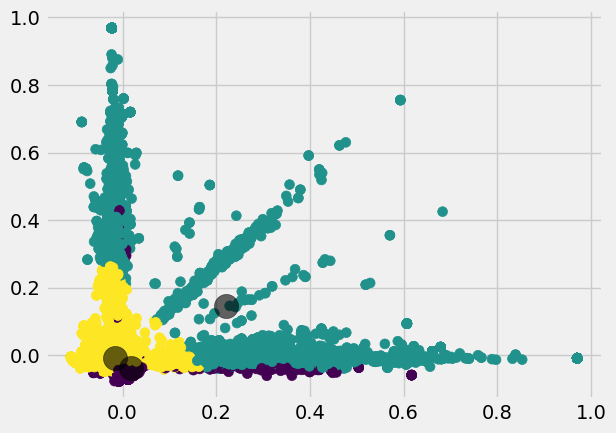

In [8]:
sklearn_pca = PCA(n_components = 4)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
test_e = Kmeans(3, 1, 600)
fitted = test_e.fit_kmeans(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = fitted.centroids
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

### SK-Learn Implementation

In [9]:
kmeans = KMeans(n_clusters=3, max_iter=10, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

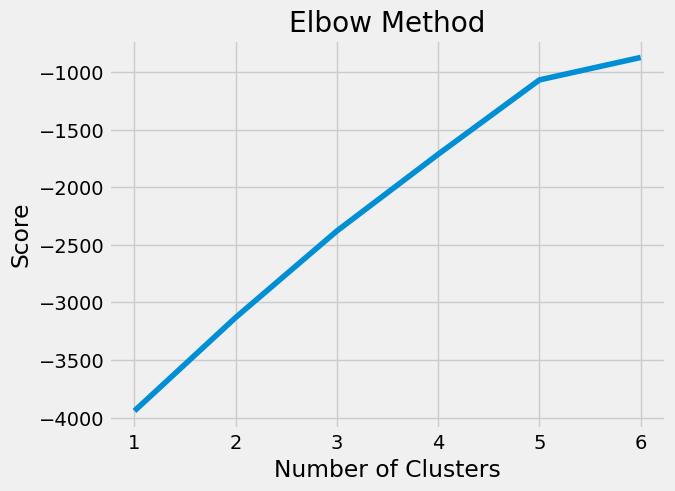

In [10]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

## Examining the Top words in each Cluster

In [11]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizor.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 15)

In [12]:
def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])
        plt.show()

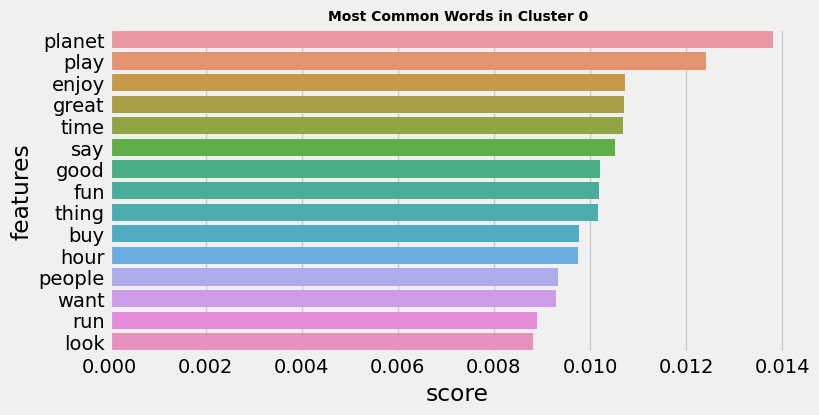

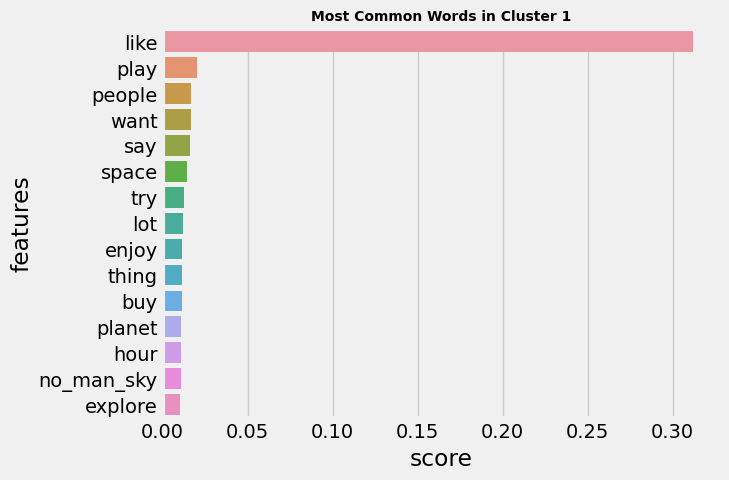

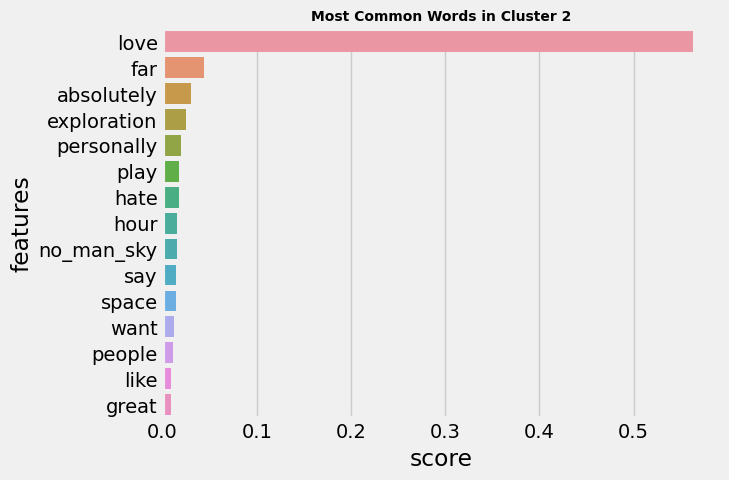

In [13]:
plotWords(dfs, 15)